# Lecture 5: Supervised Models, [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* How to train a random forest classifier with `sklearn`.

## Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

## Data

We use the well-known [handwritten digit recognition](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) data.

In [2]:
from sklearn.datasets import load_digits

data = load_digits()

Let's print some examples:

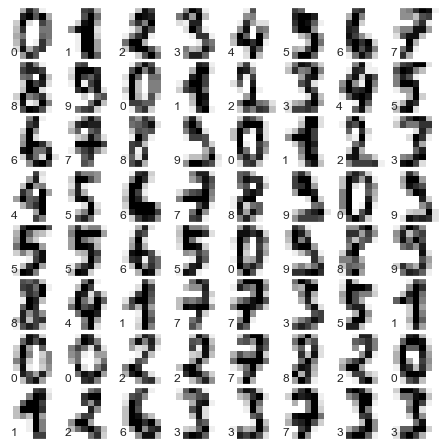

In [3]:
# from https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html#Ensembles-of-Estimators:-Random-Forests

# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(data.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(data.target[i]))

Each image was pre-processed into a 8×8 pixel image, represented as a 64-wide integer array. Each integer $\in [0,16)$. The larger the number, the darker the pixel.

In [4]:
data.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

#### Training & Test Data

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target,
                                                    random_state=2956,
                                                    train_size=0.7)

print(f'   Train   Test   Total')
print(f'X: {X_train.shape[0]}  + {X_test.shape[0]}  = {data.data.shape[0]}')
print(f'y: {y_train.shape[0]}  + {y_test.shape[0]}  = {data.target.shape[0]}')

   Train   Test   Total
X: 1257  + 540  = 1797
y: 1257  + 540  = 1797


## Forest Classifier

### Steps 1-4
We follow the `sklearn` training process as seen on the slides.

We use [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). The key hyperparameters are:
* `max_features`: the random number of features to keep in each split; the default is `'auto'`, which is the same as `sqrt(n_features)`, i.e. $\sqrt{n_{features}}$
  
  (Note that for [`RandomForestRegressor`s](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), `max_features='auto'` $\Leftrightarrow$ `max_features=n_features`.)
* `n_estimators`: the number of trees; the default is `100`, which is a good starting point
* Don't limit individual trees (e.g., pruning, `max_depth`, `min_samples_split`)

In [6]:
from sklearn.ensemble import RandomForestClassifier

# choose model & hyperparameters
model = RandomForestClassifier()

# fit
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

The model works pretty well out of the box:

In [7]:
model.score(X_test, y_test)

0.9685185185185186

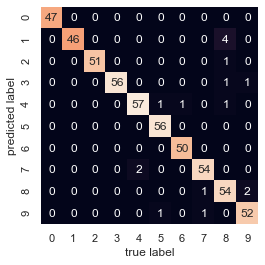

In [8]:
from sklearn.metrics import confusion_matrix

y_fit = model.predict(X_test)
cm = confusion_matrix(y_test, y_fit)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Out-of-bag (OOB) Score

By bootstrapping, each bagged tree effectively only makes use of around $2/3$ of observations. The remaining observations are called *out-of-bag* observations. Like in cross validation, we can use each tree in which an observation was out-of-bag to estimate an out-of-sample prediction for that observation.

The advantage is that, when the number of trees is sufficiently large, the OOB score is equivalent to leave-one-out CV.  But instead of the computationally expensive LOO-CV, the OOB score is much easier to calculate.

To use the OOB score, we need to set `oob_score=True` when creating the model:

In [9]:
model = RandomForestClassifier(oob_score=True)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

The OOB score is very close to the test score ...

In [10]:
model.oob_score_

0.9681782020684169

In [11]:
model.score(X_test, y_test)

0.9777777777777777

... as well as to a 5-CV:

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X_train, y_train, cv=5).mean()

0.9689748940744958

### The Number of Trees

We can see that already with a small number of trees, the out-of-bag and CV performance is very good, and there is no material improvement after 500 trees. We can also see that we need a certain number of trees for reliable OOB scores.

In [13]:
print('trees oob   cv')
for trees in [10, 20, 50, 100, 200, 500, 1000]:
    model = RandomForestClassifier(n_estimators=trees,
                                   oob_score=True)
    model.fit(X_train, y_train)
    print(f'{trees: >4}: {model.oob_score_:.3f} {cross_val_score(model, X_train, y_train, cv=5).mean():.3f}')

trees oob   cv


C:\Users\corne\Anaconda3\envs\python38\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\corne\Anaconda3\envs\python38\lib\site-packages\sklearn\ensemble\_forest.py:527: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\corne\Anaconda3\envs\python38\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\corne\Anaconda3\envs\python38\lib\site-packages\sklearn\ensemble\_forest.py:527: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\corne\Anaconda3\envs\python38\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some 

  10: 0.858 0.937


C:\Users\corne\Anaconda3\envs\python38\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\corne\Anaconda3\envs\python38\lib\site-packages\sklearn\ensemble\_forest.py:527: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


  20: 0.926 0.956
  50: 0.959 0.967
 100: 0.970 0.969
 200: 0.975 0.966
 500: 0.976 0.971
1000: 0.972 0.973


### Variable (or Feature) Importance

Sometime we want to know (for example for feature selection), which features are most important in a forest. sklearn calculates the feature importance as the fraction of samples influenced by each feature (i.e., higher features have more importance) and the reduction of impurity.

We can access it via `model.feature_importances_` (for the last model calculated in the previous loop):

In [14]:
model.feature_importances_.reshape((8,8))

array([[0.00000000e+00, 2.53284166e-03, 2.11830262e-02, 1.08240946e-02,
        9.63338825e-03, 1.86546760e-02, 8.82298457e-03, 7.25398012e-04],
       [2.58932581e-05, 1.21673540e-02, 2.64213620e-02, 6.84310977e-03,
        1.55484531e-02, 2.74778259e-02, 5.43133165e-03, 5.75204126e-04],
       [0.00000000e+00, 7.12191360e-03, 2.39114287e-02, 2.60728984e-02,
        3.08462096e-02, 5.07397138e-02, 8.17947018e-03, 1.91432321e-04],
       [3.42210922e-05, 1.39743108e-02, 3.95793579e-02, 2.43995763e-02,
        3.35718554e-02, 2.15679741e-02, 3.10920827e-02, 3.46606576e-05],
       [0.00000000e+00, 3.17071599e-02, 2.66261350e-02, 1.68460574e-02,
        4.11312808e-02, 1.85962913e-02, 2.45702720e-02, 0.00000000e+00],
       [4.29097914e-05, 1.48143197e-02, 3.67742144e-02, 4.45951225e-02,
        2.10620269e-02, 1.69978627e-02, 1.82351964e-02, 7.53390229e-05],
       [4.96135796e-05, 2.74839244e-03, 1.60909912e-02, 2.23547934e-02,
        1.38836016e-02, 2.37412960e-02, 2.36442606e-02, 1.

After reshaping the 1D array into an 8×8 2D array, we can also plot the importance in an 8×8 image:

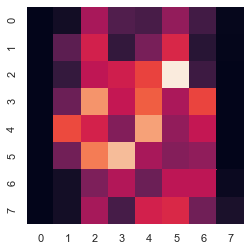

In [15]:
sns.heatmap(model.feature_importances_.reshape((8,8)),
            square=True, cbar=False);

Clearly pixels closer to the centre of the image are more important.

### Parallelisation

Creating large forests takes a lot of time:

In [16]:
%%timeit -n3 -r1

model = RandomForestClassifier(n_estimators=1000,
                               oob_score=True)
model.fit(X_train, y_train)

3.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


We can use the Jupyter magic command [`%%timeit`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) to time the execution of a cell. The average time it took to fit the model in three iterations (`-n3`) was 3.12s.

We can speed this up by training trees in separate threads. If your computer has more than one (virtual) core, training trees in separate threads (up to the number of (virtual) cores) will make the training faster.

Let's begin with two threads (`n_jobs=2`):

In [17]:
%%timeit -n3 -r1

model = RandomForestClassifier(n_estimators=1000,
                               oob_score=True,
                               n_jobs=2)
model.fit(X_train, y_train)

2.45 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


`n_jobs=4`:

In [18]:
%%timeit -n3 -r1

model = RandomForestClassifier(n_estimators=1000,
                               oob_score=True,
                               n_jobs=4)
model.fit(X_train, y_train)

2.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


`n_jobs=8`:

In [19]:
%%timeit -n3 -r1

model = RandomForestClassifier(n_estimators=1000,
                               oob_score=True,
                               n_jobs=8)
model.fit(X_train, y_train)

2.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


On my laptop with four real cores and eight virtual cores, using eight threads was actually slower than four.

You cannot use parallelisation on HackerRank.

© 2023 Philipp Cornelius